In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

# 5. Histogram patch picking

In this chapter, we will work on matching images using histograms. As in chapter 4,
we'll be working on the following classes:
  - `Patch` from `mosaic_maker.patch.patch` module
  - `PatchPicker` from `mosaic_maker.mosaic.patch_picker` module
 
Set config variables as follows, to work purely on histogram descriptor:
```python
USE_SOBEL_DESCRIPTOR = False
USE_HISTOGRAM_DESCRIPTOR = True
```

We will use a similar idea as in the image search algorithm presented in the 
`OpenCV` introduction - we will use 3d histogram as an image descriptor. For a 
better fit, we will divide the image into the grid and calculate the histogram 
for each of the grid cells separately.

You can find two values in config responsible for the grid and histogram shapes:
`HISTOGRAM_GRID_SHAPE` and `HISTOGRAM_BUCKETS`.

Again, let's start with the descriptor implementation.

In [3]:
import cv2
from matplotlib import pyplot as plt
from mosaic_maker.patch.patch import Patch
from config import PATCH_SIZE, PROJECT_ROOT

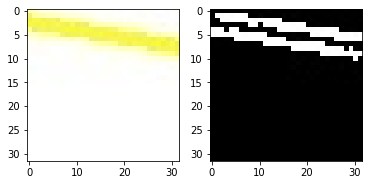

In [4]:
test_source = cv2.imread((PROJECT_ROOT / 'assets/indexed-sources/test/images/0010.jpg').as_posix())
test_source_sobel = cv2.imread(
    (PROJECT_ROOT / 'assets/indexed-sources/test/sobel-images/0010.jpg').as_posix(), 
    cv2.IMREAD_GRAYSCALE
)
_, grid = plt.subplots(1, 2)
grid[0].imshow(cv2.cvtColor(test_source, cv2.COLOR_BGR2RGB))
grid[1].imshow(test_source_sobel, cmap='gray')

In [5]:
test_patch = Patch('test', test_source, test_source_sobel)
test_patch._calculate_features()

array([0.        , 0.00035317, 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

The result will be an empty array.

Before implementing descriptor, read the following tutorials:
  - [Changing Colorspaces](https://docs.opencv.org/master/df/d9d/tutorial_py_colorspaces.html)
  - [Histograms - 1: Find, Plot, Analyze !!!](https://docs.opencv.org/master/d1/db7/tutorial_py_histogram_begins.html)
  - [Histograms - 3: 2D Histograms](https://docs.opencv.org/master/dd/d0d/tutorial_py_2d_histogram.html)

`_calculate_features` implements a loop that iterates over grid fields.
`x0, y0, x1, y1` variables denote upper left and lower right corners of
the currently processed grid cell. To calculate descriptor:
  1. extract current grid cell from the source image
  2. convert the cell to colorspace of your choice - colorspace will have a 
  significant influence on the final result
  3. calculate histogram - 3d histogram is similar to 2d. Watch out on ranges - not all
  colorspaces have values from the `0-255` range
  4. normalize histogram
  5. append flattened histogram to the features list
  

In [6]:
test_patch._calculate_features()

array([0.        , 0.00035317, 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [7]:
test_patch._calculate_features()[test_patch._calculate_features() > 0]

array([3.5317027e-04, 3.5317027e-04, 3.5317027e-04, 1.0595107e-03,
       7.0634054e-04, 1.0595107e-03, 3.5317027e-04, 3.5317027e-04,
       7.0634054e-04, 3.5317027e-04, 7.0634054e-04, 7.0634054e-04,
       3.5317027e-04, 9.0058416e-02, 8.8998906e-02, 9.0058416e-02,
       8.9352079e-02, 9.0058416e-02, 9.0058416e-02, 8.8998906e-02,
       1.4126811e-03, 1.4126811e-03, 1.4126811e-03, 7.0634054e-04,
       3.5317027e-04, 3.5317027e-04, 3.5317027e-04, 7.0634054e-04,
       3.5317027e-04, 3.5317027e-04, 3.5317027e-04, 9.0058416e-02,
       8.9352079e-02, 9.0058416e-02, 9.0058416e-02, 9.0058416e-02,
       8.9705251e-02, 9.0058416e-02, 8.8645734e-02, 9.0058416e-02,
       9.0058416e-02, 9.0058416e-02, 9.0058416e-02, 9.0058416e-02,
       3.5317027e-04, 7.0634054e-04, 3.5317027e-04, 3.5317027e-04,
       7.0634054e-04, 3.5317027e-04, 7.0634054e-04, 3.5317027e-04,
       7.0634054e-04, 7.0634054e-04, 9.0058416e-02, 8.9705251e-02,
       7.0634054e-04, 9.0058416e-02, 8.9352079e-02, 8.9705251e

As we updated descriptor, we'll have to rerun indexing to make `PatchPicker` work.

In [8]:
from mosaic_maker.index_assets import index_images
from config import IMAGES_SET
index_images(IMAGES_SET, PATCH_SIZE)

PROCESSING FILES:
  > 0068.jpg  DONE


Having a new descriptor work we can update `pick_patch_for` method of the 
`PatchPicker` class.

As before, you will need to extract the histogram from feature vector -
`HISTOGRAM_VECTOR_LENGTH` constant from config may come in handy. 

For the histograms comparison, us
[`compareHist`](https://docs.opencv.org/master/d6/dc7/group__imgproc__hist.html#gaf4190090efa5c47cb367cf97a9a519bd)
function. Experiment with different distances to find the best matching 
algorithm.

As for choosing the best patch, use `argmin` as in the case of Sobel 
descriptors.

In [9]:
from mosaic_maker.mosaic.patch_picker import PatchPicker

patch_picker = PatchPicker('test', PROJECT_ROOT / 'assets/indexed-sources/test')

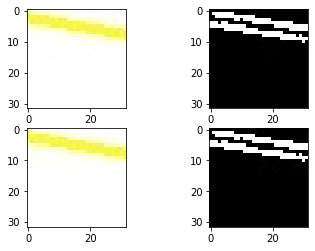

In [10]:
test_patch = Patch('test', test_source, test_source_sobel)
selected_patch = patch_picker.pick_patch_for(test_patch)
_, grid = plt.subplots(2, 2)
grid[0, 0].imshow(cv2.cvtColor(test_source, cv2.COLOR_BGR2RGB))
grid[0, 1].imshow(test_source_sobel, cmap='gray')
grid[1, 0].imshow(cv2.cvtColor(selected_patch.image, cv2.COLOR_BGR2RGB))
grid[1, 1].imshow(selected_patch.sobel_image, cmap='gray')

The match should be perfect if implemented correctly. Let's see how the 
algorithm behaves for the test image.

The next block may run for a while. Running `compose_mosaic` main function 
may be more convenient for experimentation.


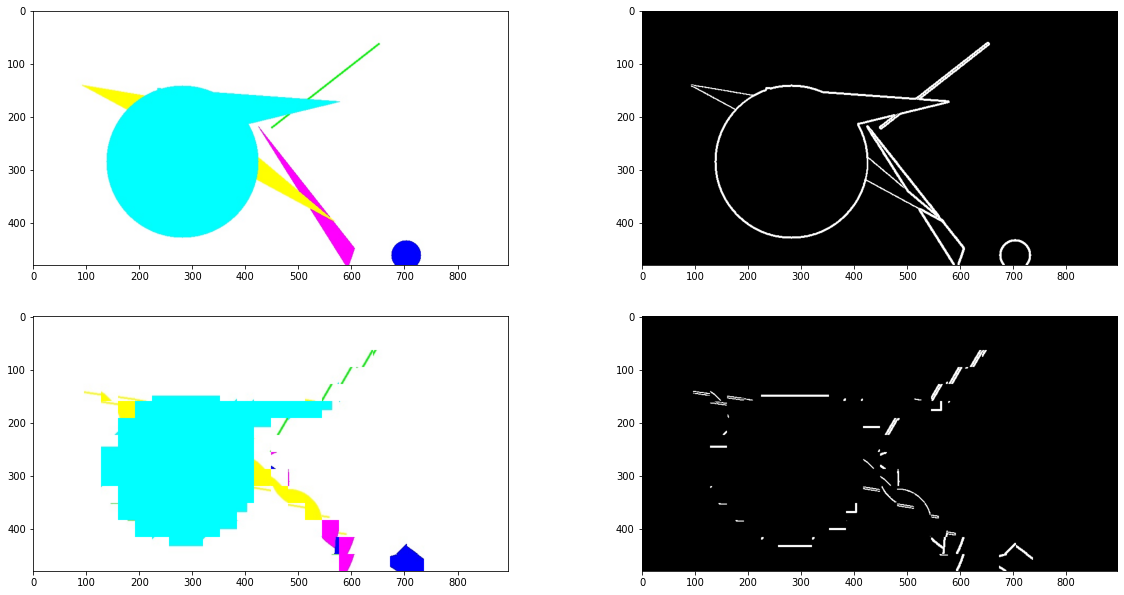

In [11]:
import numpy as np
from mosaic_maker.mosaic.mosaic_image import MosaicImage

image_path = PROJECT_ROOT / 'assets/test-target.jpg'
test_image = cv2.imread(image_path.as_posix())
mosaic_image = MosaicImage(test_image, PATCH_SIZE, patch_picker)

target_image_copy = mosaic_image.target_image.copy()
target_sobel_image_copy = mosaic_image.target_sobel_image.copy()
mosaic = np.zeros(mosaic_image.target_image.shape, np.uint8)
sobel_mosaic = np.zeros(mosaic_image.target_sobel_image.shape, np.uint8)

(height, width) = target_image_copy.shape[:2]
mosaic_image._compose_mosaic_for(width, height, 
                                 mosaic, sobel_mosaic, 
                                 target_image_copy, target_sobel_image_copy)

_, grid = plt.subplots(2, 2, figsize=(20, 10.3))
grid[0, 0].imshow(cv2.cvtColor(mosaic_image.target_image, cv2.COLOR_BGR2RGB))
grid[0, 1].imshow(mosaic_image.target_sobel_image, cmap='gray')
grid[1, 0].imshow(cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))
grid[1, 1].imshow(sobel_mosaic, cmap='gray')


The result should resemble original pretty well on a color image, but Sobel 
images will be way less aligned than before.


You may need to iterate and test different histogram configurations and 
comparison functions to obtain the best results.

![title](assets/5-histogram-picking/hist-result.png)